In [394]:
import math

import numpy as np
import pandas as pd

from sklearn import tree
from sklearn import ensemble

from tqdm.notebook import tqdm as log_progress

import matplotlib.pyplot as plt

In [371]:
def load_dataset(filepath):
    ds_tmp = pd.read_csv(filepath)
    Y = ds_tmp[['y']]
    X = ds_tmp.loc[:, ds_tmp.columns != 'y']
    return X, Y

In [402]:
def build_and_fit(X, Y, criterion, splitter, max_depth):
    clf = tree.DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth)
    clf = clf.fit(X, Y.values.T[0])
    return clf

In [373]:
def count_accuracy(clf, tX, tY):
    true_count = 0
    total = tX.shape[0]
    predict_Y = clf.predict(tX)
    for predict, target in zip(predict_Y, tY.values.T[0]):
        if predict == target:
            true_count += 1
    return true_count / total

## Building parameter set and counting res

In [374]:
params = []
for h in range(3, 25):
    for c in ['gini', 'entropy']:
        for s in ['best', 'random']:
            params.append((h, c, s))
results = {i: {} for i in range(1, 22)}

In [375]:
for i in log_progress(range(1, 22)):
    prefix = 'data/{:02d}'.format(i)
    X, Y = load_dataset(prefix + '_train.csv')
    tX, tY = load_dataset(prefix + '_test.csv')
    for ps in params:
        if ps in results[i]:
            continue
        (height, cr, spl) = ps
        clf = build_and_fit(X, Y, cr, spl, height)
        acc = count_accuracy(clf, tX, tY)
        
        results[i][ps] = (acc, clf.get_depth())

In [376]:
sorted_results = list(map(lambda r: (r[0], sorted(r[1].items(), key=lambda e: -e[1][0])), results.items()))
best_results = list(map(lambda r: (r[0], r[1][0]), sorted_results))
best_results

[(1, ((3, 'entropy', 'best'), (0.9997429966589566, 3))),
 (2, ((9, 'entropy', 'best'), (0.7030534351145038, 9))),
 (3, ((3, 'entropy', 'best'), (1.0, 3))),
 (4, ((5, 'entropy', 'best'), (0.992, 5))),
 (5, ((3, 'gini', 'best'), (0.9956709956709957, 3))),
 (6, ((3, 'entropy', 'best'), (0.9988962472406181, 3))),
 (7, ((3, 'entropy', 'best'), (0.9967441860465116, 3))),
 (8, ((3, 'gini', 'best'), (0.997920997920998, 3))),
 (9, ((5, 'entropy', 'best'), (0.8450980392156863, 5))),
 (10, ((4, 'entropy', 'best'), (0.9979879275653923, 4))),
 (11, ((3, 'entropy', 'best'), (0.999195171026157, 3))),
 (12, ((8, 'entropy', 'best'), (0.8773505472916082, 8))),
 (13, ((7, 'entropy', 'best'), (0.6513761467889908, 7))),
 (14, ((5, 'entropy', 'best'), (0.990351215746816, 5))),
 (15, ((4, 'entropy', 'best'), (0.9993993993993994, 4))),
 (16, ((3, 'entropy', 'best'), (1.0, 3))),
 (17, ((7, 'entropy', 'best'), (0.8447794528196538, 7))),
 (18, ((5, 'entropy', 'best'), (0.9426656738644825, 5))),
 (19, ((7, 'entro

## Some drawings

In [377]:
def draw_accuracy(results, params):
    (_, cr, spl) = params
    filtered = list(filter(lambda x: x[0][1] == cr and x[0][2] == spl, results))
    sorted_by_h = list(map(lambda x: (x[0][0], x[1][0]), sorted(filtered, key=lambda x: x[0][0])))
    xd = [x for x, _ in sorted_by_h]
    yd = [y for _, y in sorted_by_h]
    
    plt.figure(figsize=(10, 7))
    plt.xlabel('requested tree depth')
    plt.ylabel('accuracy')
    plt.plot(xd, yd, label=str((cr, spl)))
    plt.legend()
    plt.show()
    
    
    sorted_by_th = list(map(lambda x: (x[0][0], x[1][1]), sorted(filtered, key=lambda x: x[0][0])))
    xd = [x for x, _ in sorted_by_th]
    yd = [y for _, y in sorted_by_th]
    
    plt.figure(figsize=(10, 7))
    plt.xlabel('requested tree depth')
    plt.ylabel('real average tree depth')
    plt.plot(xd, yd, label=str((cr, spl)))
    plt.legend()
    plt.show()

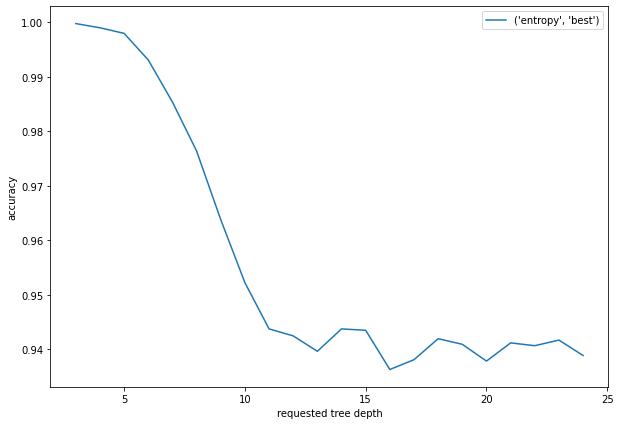

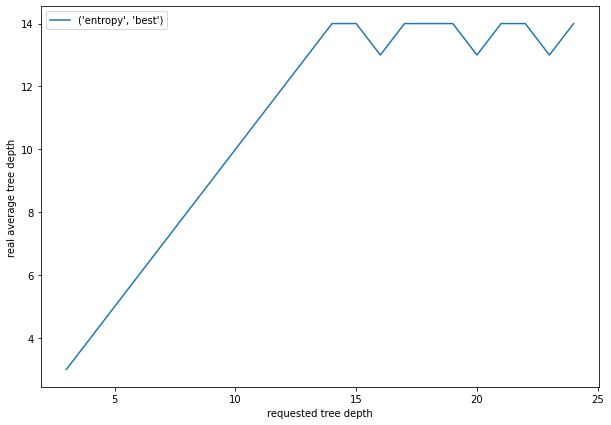

In [378]:
draw_accuracy(sorted_results[0][1], sorted_results[0][1][0][0])

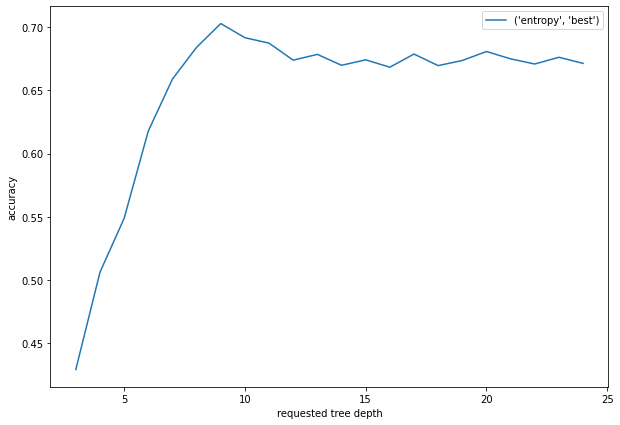

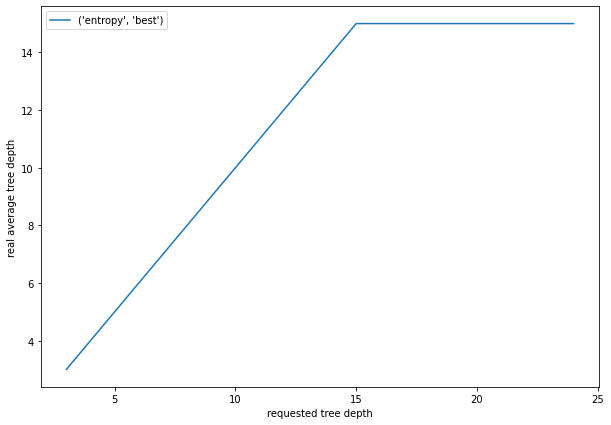

In [379]:
draw_accuracy(sorted_results[1][1], sorted_results[1][1][0][0])

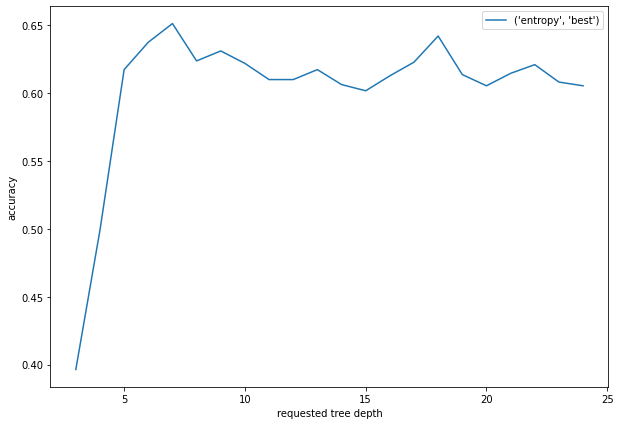

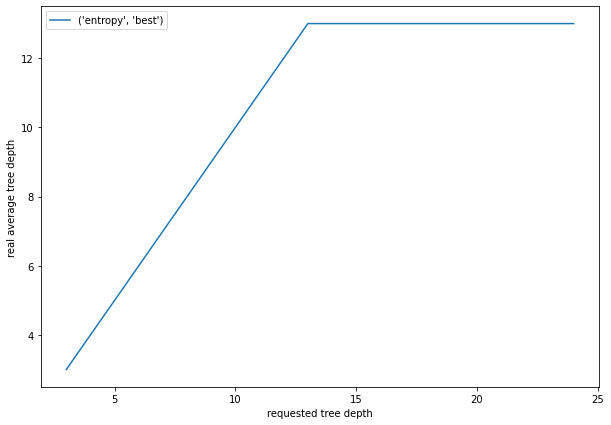

In [380]:
draw_accuracy(sorted_results[12][1], sorted_results[12][1][0][0])

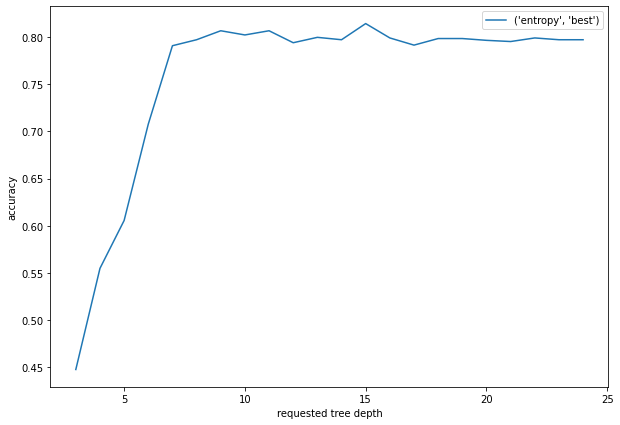

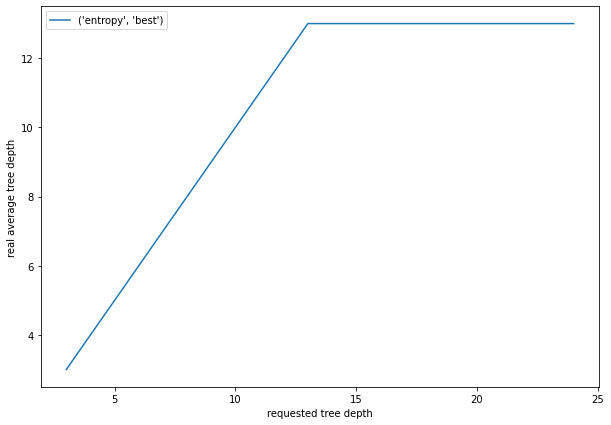

In [381]:
draw_accuracy(sorted_results[20][1], sorted_results[20][1][0][0])

## Creating a forest

In [417]:
class ForrestClassificator:
    cls = []
    
    def __init__(self, reps, cr, spl, full=False):
        self.repititions = reps
        self.criterion = cr
        self.splitter = spl
        self.clfs = []
        self.full_columns = full
        
    def fit(self, X, Y):
        l, n = X.shape
        for i in range(self.repititions):
            rows = np.random.choice(X.index.values, l)
            X1 = X.loc[rows, :]
            Y2 = Y.loc[rows, :]
            
            X2 = None
            if self.full_columns:
                X2 = X1
            else:
                X2 = X1.sample(n=int(math.sqrt(n)), axis='columns') # random sqrt(n) columns
            # print(X.shape, X2.drop_duplicates().shape)
            
            self.clfs.append((X2.columns, build_and_fit(X2, Y2, self.criterion, self.splitter, None)))
            
    def predict(self, tX):
        results = np.empty((len(self.clfs), tX.shape[0]), dtype=np.int64)
        for i in range(len(self.clfs)):
            cols, clf = self.clfs[i]
            results[i] = clf.predict(tX[cols])
        results = results.T
        result = np.empty(len(results))
        for i in range(len(results)):
            result[i] = np.bincount(results[i]).argmax()
        return result

In [412]:
fresults = {}

In [418]:
for i in range(1, 22):
    prefix = 'data/{:02d}'.format(i)
    X, Y = load_dataset(prefix + '_train.csv')
    tX, tY = load_dataset(prefix + '_test.csv')
    
    fclf = ForrestClassificator(100, 'gini', 'random')
    fclf.fit(X, Y)

    acc_train = count_accuracy(fclf, X, Y)
    acc_test  = count_accuracy(fclf, tX, tY)
    
    
    fclf = ForrestClassificator(100, 'gini', 'random', True)
    fclf.fit(X, Y)

    acc_train_f = count_accuracy(fclf, X, Y)
    acc_test_f  = count_accuracy(fclf, tX, tY)


    fclf_sklrn = ensemble.RandomForestClassifier(n_estimators=100, criterion='gini')
    fclf_sklrn.fit(X, Y.values.T[0])

    acc_train_sk = count_accuracy(fclf_sklrn, X, Y)
    acc_test_sk  = count_accuracy(fclf_sklrn, tX, tY)

    fresults[i] = ((acc_train, acc_test), (acc_train_f, acc_test_f), (acc_train_sk, acc_test_sk))

In [419]:
fresults

{1: ((1.0, 0.7887432536622976),
  (0.9997429966589566, 0.9933179131328708),
  (1.0, 0.9989719866358263)),
 2: ((1.0, 0.19338422391857507),
  (1.0, 0.5162849872773537),
  (1.0, 0.5376590330788804)),
 3: ((1.0, 0.8659594985535197),
  (1.0, 0.9995178399228544),
  (1.0, 0.9995178399228544)),
 4: ((1.0, 0.5711304347826087),
  (1.0, 0.959304347826087),
  (1.0, 0.9384347826086956)),
 5: ((1.0, 0.922077922077922),
  (1.0, 0.9978354978354979),
  (1.0, 0.9956709956709957)),
 6: ((1.0, 0.5921633554083885),
  (1.0, 0.9900662251655629),
  (1.0, 0.9950331125827815)),
 7: ((1.0, 0.4730232558139535),
  (1.0, 0.958139534883721),
  (1.0, 0.9469767441860465)),
 8: ((1.0, 0.9708939708939709),
  (1.0, 0.9708939708939709),
  (1.0, 0.9708939708939709)),
 9: ((1.0, 0.3686274509803922),
  (1.0, 0.7274509803921568),
  (1.0, 0.7607843137254902)),
 10: ((1.0, 0.7887323943661971),
  (1.0, 0.9806841046277666),
  (1.0, 0.9971830985915493)),
 11: ((1.0, 0.7835010060362173),
  (1.0, 0.999195171026157),
  (1.0, 0.99919

## Results explanation?
I can't invade into decision tree building process with custom criterion that will take only n' of values. Missing values are also not supported by algo, the only way I figured out to do this - is taking n' of columns before building a tree. As I can see, it works really bad comparing to RandomForest from sklearn.
Not cutting off columns for n' effects in better classification

Also it's easy to see that accuracy on train data must be 1 or really-really close, that's obvious